In [71]:
from pringles.simulator import Simulator
mySimulator = Simulator(cdpp_bin_path='bin/', user_models_dir='src/')

In [72]:
for atomic in mySimulator.atomic_registry.discovered_atomics:
    if atomic.__name__ == "Server":
        Server = atomic
    elif atomic.__name__ == "AutoScaler":
        AutoScaler = atomic
    elif atomic.__name__ == "ServerQueue":
        ServerQueue = atomic
    elif atomic.__name__ == "Dispatcher":
        Dispatcher = atomic

print(Server)
print(Dispatcher)
print(ServerQueue)

<class 'pringles.models.models.Server'>
<class 'pringles.models.models.Dispatcher'>
<class 'pringles.models.models.ServerQueue'>


In [73]:
from pringles.models import Coupled
from pringles.models.errors import PortNotFoundException
number_of_servers = 3
a_dispatcher = Dispatcher("a_dispatcher", 
                          numberOfServers=number_of_servers, 
                          server0="free",
                          server1="free",
                          server2="free")
server0 = Server("server0", initialStatus="free", mean=10.0, setupTime="0:0:10:0")
servers = {}
for i in range(number_of_servers):
    server_name = "server" + str(i)
    servers[i] = Server(server_name, initialStatus="free", mean=10.0, setupTime="0:0:10:0")
    try:
        a_dispatcher.get_port(server_name)
    except PortNotFoundException:
        a_dispatcher.add_outport(server_name)

a_queue = ServerQueue("a_queue", size=10)
    
print("--Dispatcher ports")
print("Inport names: ", [port.name for port in a_dispatcher.inports])
print("Outport names: ", [port.name for port in a_dispatcher.outports])

print("--Server ports--")
print("Inport names: ", [port.name for port in servers[0].inports])
print("Outport names: ", [port.name for port in servers[0].outports])

print("--ServerQueue ports--")
print("Inport names: ", [port.name for port in a_queue.inports])
print("Outport names: ", [port.name for port in a_queue.outports])

--Dispatcher ports
Inport names:  ['newJob', 'jobDone', 'serverStackInfo']
Outport names:  ['requestJob', 'server0', 'server1', 'server2']
--Server ports--
Inport names:  ['job', 'powerSignal']
Outport names:  ['done', 'ready']
--ServerQueue ports--
Inport names:  ['in', 'emit']
Outport names:  ['out', 'discarded', 'current_size']


In [74]:
subcomponents = [a_dispatcher, a_queue]
for i in range(number_of_servers):
    subcomponents.append(servers[i])
    
    
top_model = (Coupled(name='top', subcomponents=subcomponents)
             .add_inport("newJob")
             .add_inport("serverStackInfo")
             
             .add_coupling('serverStackInfo', a_dispatcher.get_port("serverStackInfo"))
            
             .add_coupling(a_dispatcher.get_port('server0'), servers[0].get_port('job'))
             .add_coupling(a_dispatcher.get_port('server1'), servers[1].get_port('job'))
             .add_coupling(a_dispatcher.get_port('server2'), servers[2].get_port('job'))
             
             .add_coupling(servers[0].get_port('done'), a_dispatcher.get_port('jobDone'))
             .add_coupling(servers[1].get_port('done'), a_dispatcher.get_port('jobDone'))
             .add_coupling(servers[2].get_port('done'), a_dispatcher.get_port('jobDone'))
             
             .add_coupling("newJob", a_queue.get_port('in'))
             .add_coupling(a_queue.get_port("out"), a_dispatcher.get_port("newJob"))
             .add_coupling(a_dispatcher.get_port("requestJob"), a_queue.get_port("emit"))

             
            )
top_model

In [75]:
from pringles.simulator import Simulation, Event
from pringles.utils import VirtualTime
# Empiezan los 3 servidores prendidos. Y se avisa que el 2 está apagado (habría que mandarle tmb que se apague)
# Llega un Job a los 25 y el dispatcher lo debería mandar al server 0 porque es el de menor ID
# Llega que se prendió de nuevo el server 2
# Llega otro Job a los 38 y se los manda de nuevo al server 0 (en la simulación el server 0 termina el job anterior
    # en el segundo 36)
# Llega en 40 que se apagó el 0, pero el lo tenía en busy, espera que se apague y lo pasa a off
# Llega en 42 un Job y como el 0 está en apagado/busy, se lo manda al server 1
# Llega en 43 que se apague el 1, espera que se termine el job y lo apaga
# Llega en 44 un Job y se lo manda al server 2, el único prendido

sim_events = [
    Event(VirtualTime(0,0,20,0,0), top_model.get_port('serverStackInfo'), [float(2),float(0)]),
    Event(VirtualTime(0,0,25,0,0), top_model.get_port('newJob'), float(1)),
    Event(VirtualTime(0,0,35,0,0), top_model.get_port('serverStackInfo'), [float(2),float(1)]),
    Event(VirtualTime(0,0,38,0,0), top_model.get_port('newJob'), float(1)),
    Event(VirtualTime(0,0,40,0,0), top_model.get_port('serverStackInfo'), [float(0),float(0)]),
    Event(VirtualTime(0,0,42,0,0), top_model.get_port('newJob'), float(1)),
    Event(VirtualTime(0,0,43,0,0), top_model.get_port('serverStackInfo'), [float(1),float(0)]),
    Event(VirtualTime(0,0,44,0,0), top_model.get_port('newJob'), float(1)),
]


a_simulation = Simulation(top_model = top_model, 
                          duration = VirtualTime.of_minutes(50), 
                          events=sim_events,
                          working_dir='sim_results/'
                         )

results = mySimulator.run_simulation(a_simulation)

In [76]:
print(results.get_process_output())

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from sim_results/2019-10-12-191628-3bdd12d3ce5a4d96a638161b41846bb6/top_model
Loading events from sim_results/2019-10-12-191628-3bdd12d3ce5a4d96a638161b41846bb6/events
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Mess

In [77]:
print(results.get_process_error_output())

At 00:50:00:000:0


In [79]:
display(results.output_df.head(100))

,time,port,value


In [80]:
print(results.logs_dfs.keys(),'\n\n')
display(results.logs_dfs['ParallelRoot'].head())

dict_keys(['server2', 'server1', 'server0', 'a_queue', 'a_dispatcher', 'top', 'ParallelRoot']) 




,0,1,message_type,time,model_origin,port,value,model_dest


In [81]:
# Veamos que le llegan al server 0 los primneros 2 jobs, hasta que lo apagan en segundo 40
display(results.logs_dfs['server0'])

,0,1,message_type,time,model_origin,port,value,model_dest
0,0,L,X,00:00:25:000,top(06),job,0.0,server0(03)
1,0,L,X,00:00:38:000,top(06),job,1.0,server0(03)


In [82]:
# Veamos que el siguiente job le llega al server 1 en el segundo 42, y luego lo apagan en el segundo 43
# Y se espera a que termine para apagarlo
display(results.logs_dfs['server1'])

,0,1,message_type,time,model_origin,port,value,model_dest
0,0,L,X,00:00:42:000,top(06),job,2.0,server1(04)


In [83]:
# Por último cuando el 0 y el 1 están apagados, cuando llega el último job en el segundo 44, se lo envía al server 2
# que lo termina (ver logs dispatcher)
display(results.logs_dfs['server2'])

,0,1,message_type,time,model_origin,port,value,model_dest
0,0,L,X,00:00:44:000,top(06),job,3.0,server2(05)


In [84]:
display(results.logs_dfs['a_dispatcher'])

,0,1,message_type,time,model_origin,port,value,model_dest
0,0,L,X,00:00:20:000,top(06),serverstackinfo,"(2.0, 0.0)",a_dispatcher(01)
1,0,L,X,00:00:25:000,top(06),newjob,1,a_dispatcher(01)
2,0,L,X,00:00:31:116,top(06),jobdone,0,a_dispatcher(01)
3,0,L,X,00:00:35:000,top(06),serverstackinfo,"(2.0, 1.0)",a_dispatcher(01)
4,0,L,X,00:00:38:000,top(06),newjob,1,a_dispatcher(01)
5,0,L,X,00:00:40:000,top(06),serverstackinfo,"(0.0, 0.0)",a_dispatcher(01)
6,0,L,X,00:00:42:000,top(06),newjob,1,a_dispatcher(01)
7,0,L,X,00:00:42:777,top(06),jobdone,2,a_dispatcher(01)
8,0,L,X,00:00:43:000,top(06),serverstackinfo,"(1.0, 0.0)",a_dispatcher(01)
9,0,L,X,00:00:44:000,top(06),newjob,1,a_dispatcher(01)


# Ahora vamos a probar con una simulación un poco más grande

In [85]:
sim_events = [
    Event(VirtualTime(0,0,20,0,0), top_model.get_port('serverStackInfo'), [float(2),float(0)]),
    Event(VirtualTime(0,0,25,0,0), top_model.get_port('newJob'), float(0)),
    Event(VirtualTime(0,0,35,0,0), top_model.get_port('serverStackInfo'), [float(2),float(1)]),
    Event(VirtualTime(0,0,38,0,0), top_model.get_port('newJob'), float(1)),
    Event(VirtualTime(0,0,40,0,0), top_model.get_port('serverStackInfo'), [float(0),float(0)]),
    Event(VirtualTime(0,0,42,0,0), top_model.get_port('newJob'), float(2)),
    Event(VirtualTime(0,0,43,0,0), top_model.get_port('serverStackInfo'), [float(1),float(0)]),
    Event(VirtualTime(0,0,44,0,0), top_model.get_port('newJob'), float(3)),
    Event(VirtualTime(0,0,60,0,0), top_model.get_port('newJob'), float(4)),
    Event(VirtualTime(0,0,60,0,0), top_model.get_port('newJob'), float(5)),
    Event(VirtualTime(0,0,60,0,0), top_model.get_port('newJob'), float(6)),
    Event(VirtualTime(0,0,60,0,0), top_model.get_port('newJob'), float(7)),
    Event(VirtualTime(0,1,2,0,0), top_model.get_port('newJob'), float(8)),
    Event(VirtualTime(0,1,5,0,0), top_model.get_port('serverStackInfo'), [float(1),float(1)]),
    Event(VirtualTime(0,1,8,0,0), top_model.get_port('newJob'), float(9)),

]

a_simulation = Simulation(top_model = top_model, 
                          duration = VirtualTime.of_minutes(50), 
                          events=sim_events,
                          working_dir='sim_results/'
                         )

results = mySimulator.run_simulation(a_simulation)

In [86]:
display(results.logs_dfs['server0'])

,0,1,message_type,time,model_origin,port,value,model_dest
0,0,L,X,00:00:25:000,top(06),job,0.0,server0(03)
1,0,L,X,00:00:38:000,top(06),job,1.0,server0(03)


In [87]:
display(results.logs_dfs['server1'])

,0,1,message_type,time,model_origin,port,value,model_dest
0,0,L,X,00:00:42:000,top(06),job,2.0,server1(04)
1,0,L,X,00:01:05:000,top(06),job,8.0,server1(04)
2,0,L,X,00:01:08:000,top(06),job,9.0,server1(04)


In [88]:
display(results.logs_dfs['server2'])

,0,1,message_type,time,model_origin,port,value,model_dest
0,0,L,X,00:00:44:000,top(06),job,3.0,server2(05)
1,0,L,X,00:01:00:000,top(06),job,4.0,server2(05)
2,0,L,X,00:01:00:239,top(06),job,5.0,server2(05)
3,0,L,X,00:01:01:123,top(06),job,6.0,server2(05)
4,0,L,X,00:01:03:056,top(06),job,7.0,server2(05)


In [89]:
display(results.logs_dfs['a_dispatcher'])

,0,1,message_type,time,model_origin,port,value,model_dest
0,0,L,X,00:00:20:000,top(06),serverstackinfo,"(2.0, 0.0)",a_dispatcher(01)
1,0,L,X,00:00:25:000,top(06),newjob,0,a_dispatcher(01)
2,0,L,X,00:00:31:116,top(06),jobdone,0,a_dispatcher(01)
3,0,L,X,00:00:35:000,top(06),serverstackinfo,"(2.0, 1.0)",a_dispatcher(01)
4,0,L,X,00:00:38:000,top(06),newjob,1,a_dispatcher(01)
5,0,L,X,00:00:40:000,top(06),serverstackinfo,"(0.0, 0.0)",a_dispatcher(01)
6,0,L,X,00:00:42:000,top(06),newjob,2,a_dispatcher(01)
7,0,L,X,00:00:42:777,top(06),jobdone,2,a_dispatcher(01)
8,0,L,X,00:00:43:000,top(06),serverstackinfo,"(1.0, 0.0)",a_dispatcher(01)
9,0,L,X,00:00:44:000,top(06),newjob,3,a_dispatcher(01)


In [90]:
display(results.logs_dfs['a_queue'])

,0,1,message_type,time,model_origin,port,value,model_dest
0,0,L,X,00:00:00:000,top(06),emit,1.0,a_queue(02)
1,0,L,X,00:00:25:000,top(06),in,0.0,a_queue(02)
2,0,L,X,00:00:25:000,top(06),emit,1.0,a_queue(02)
3,0,L,X,00:00:38:000,top(06),in,1.0,a_queue(02)
4,0,L,X,00:00:38:000,top(06),emit,1.0,a_queue(02)
5,0,L,X,00:00:42:000,top(06),in,2.0,a_queue(02)
6,0,L,X,00:00:42:000,top(06),emit,1.0,a_queue(02)
7,0,L,X,00:00:44:000,top(06),in,3.0,a_queue(02)
8,0,L,X,00:00:44:330,top(06),emit,1.0,a_queue(02)
9,0,L,X,00:01:00:000,top(06),in,4.0,a_queue(02)


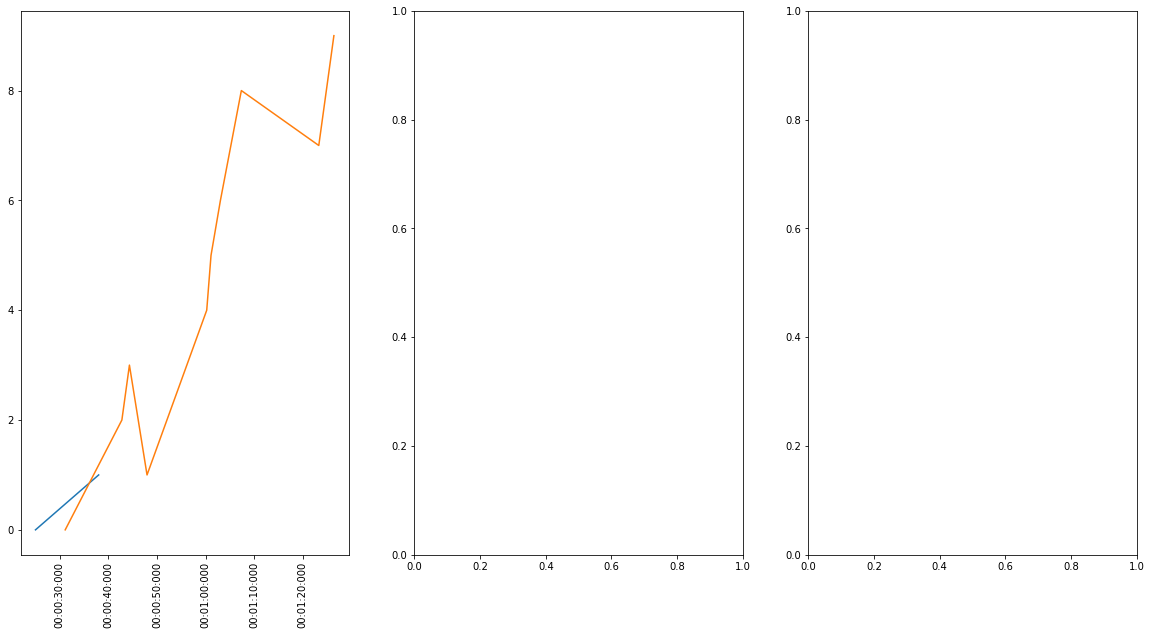

In [107]:
import matplotlib.pyplot as plt
from pringles.utils import vtime_decorate
import pandas as pd

logname = 'a_dispatcher'
portname = 'jobdone'
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

results.plot_port('server0', 'job', axes=vtime_decorate(axes[0]), index=0)
results.plot_port('a_dispatcher', 'jobdone', axes=vtime_decorate(axes[0]), index=0)


# log: pd.DataFrame = results.logs_dfs[logname]
# print(log)
# data_to_plot = log[log[results.PORT_COL] == portname]
# # print(log)
# print(data_to_plot)
# if data_to_plot.empty:
#    print("No Data!")
# if isinstance(data_to_plot[self.VALUE_COL].iloc[0], tuple):
#     y_values = data_to_plot[self.VALUE_COL].map(lambda x: x[index])
# else:
#     y_values = data_to_plot[self.VALUE_COL]

# if axes is None:
#     axes = vtime_decorate(plt.axes())  # Create a new axes in current figure
# x_values = data_to_plot[self.TIME_COL]
# axes.plot(x_values, y_values)
# return axes

In [106]:
results.logs_dfs

{'server2':    0  1 message_type          time model_origin port  value   model_dest
 0  0  L            X  00:00:44:000      top(06)  job    3.0  server2(05)
 1  0  L            X  00:01:00:000      top(06)  job    4.0  server2(05)
 2  0  L            X  00:01:00:239      top(06)  job    5.0  server2(05)
 3  0  L            X  00:01:01:123      top(06)  job    6.0  server2(05)
 4  0  L            X  00:01:03:056      top(06)  job    7.0  server2(05),
 'server1':    0  1 message_type          time model_origin port  value   model_dest
 0  0  L            X  00:00:42:000      top(06)  job    2.0  server1(04)
 1  0  L            X  00:01:05:000      top(06)  job    8.0  server1(04)
 2  0  L            X  00:01:08:000      top(06)  job    9.0  server1(04),
 'server0':    0  1 message_type          time model_origin port  value   model_dest
 0  0  L            X  00:00:25:000      top(06)  job    0.0  server0(03)
 1  0  L            X  00:00:38:000      top(06)  job    1.0  server0(03),
 '